<a href="https://colab.research.google.com/github/YuxingW/alternusvera-spring-2021/blob/main/microfactor_training_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CMPE 257 - MLSprings 2021 Cohort
Objective: Detect fake news in political datasets using factors
mircro factors <br />
Team DataCorps - Yuxing Wang, Arun Talkad, Mayuri Lalwani

## True-o-meter Pipeline

Micorfactors for Factor - Sychology Utilities, Yuxing
* Sentiment
* Group confirmation
* Opinion leader

Micorfactors for Factor - Intent, Mayuri
* Utterance
* Speech
* Sentiment

Micorfactors for Factor -Incredibility, Arun
* Incredibility

Reference: 
* https://towardsai.net/p/nlp/sentiment-analysis-opinion-mining-with-python-nlp-tutorial-d1f173ca4e3c
* https://github.com/towardsai/tutorials/tree/master/sentiment_analysis_tutorial
* https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/


## 1.Data Preparation
* Scrape data from politifact
* Fetch twitter tweets by APIs

###1.1.Scrape data from politifact

In [1]:
!pip install -q beautifulsoup4
!pip install -q vaderSentiment

**Import Required Packages**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import re
import requests
import string
from string import punctuation
from sklearn.preprocessing import StandardScaler
from io import BytesIO
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def scrape_data_from_politifact(start=1, end=10):
  url = "https://www.politifact.com/issues/"
  issues = []
  r = requests.get(url)
  soup = BeautifulSoup(r.text,'html.parser')
  results = soup.find_all('div', attrs={'class':'c-chyron__value'})
  for result in results:
    name = result.find('a').text
    issue = result.find('a')['href'].replace("/","")
    issues.append((name, issue))
  url = "https://www.politifact.com/factchecks/list/?page={pgno}&category={category}"

  records = []  

  for i in range(start,end):
    for issue, issue_url in issues[0:5]:
      fUrl = url.format(pgno=str(i), category=issue_url)
      r = requests.get(fUrl)
      soup = BeautifulSoup(r.text, 'html.parser')  
      results = soup.find_all('article', attrs={'class':'m-statement'})
      for result in results:
        date = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[1].rstrip("\n")
        reporter = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[0].replace("\nBy","")   
        author = result.find('a',attrs={'class':'m-statement__name'}).text.replace("\n","")
        statement =  result.find('div', attrs = {'class':'m-statement__quote'}).find('a').text.replace("\n","")
        statement_descr = result.find('div', {'class':'m-statement__desc'}).text.replace("\n","")
        article_url =  result.find('a')['href']
        verdict = result.find('img', attrs = {'class':'c-image__thumb'}, alt=True).attrs['alt']
        records.append(( date, issue, reporter, author, statement, statement_descr, verdict, article_url))
  return records

records = scrape_data_from_politifact()
df_politifact = pd.DataFrame(records,
                         columns=['Date', 'Issue','Reporter','Author', 'Statement', 'Description', 'Verdict', 'Url'])  
df_politifact.head()

,Date,Issue,Reporter,Author,Statement,Description,Verdict,Url
0,"May 7, 2021",Abortion,Bill McCarthy,Facebook posts,"Says Chelsea Clinton tweeted, ""If Jesus were a...","stated on May 7, 2021 in a Facebook post:",pants-fire,/personalities/facebook-posts/
1,"March 31, 2021",Abortion,Tom Kertscher,Facebook posts,“Joe Biden puts pro-life groups on domestic ex...,"stated on March 29, 2021 in a Facebook post:",barely-true,/personalities/facebook-posts/
2,"February 12, 2021",Abortion,Brandon Mulder,Greg Abbott,“Innocent lives will be saved” by ending taxpa...,"stated on January 24, 2021 in a tweet:",false,/personalities/greg-abbott/
3,"November 18, 2020",Abortion,Noah Y. Kim,Facebook posts,There is “aborted male fetus” in the Oxford-As...,"stated on November 15, 2020 in a Facebook post:",false,/personalities/facebook-posts/
4,"October 14, 2020",Abortion,Tom Kertscher,Tommy Tuberville,"Says Doug Jones ""has voted to spend our tax do...","stated on October 8, 2020 in an ad:",false,/personalities/tommy-tuberville/


###1.2.Scrape data from twitter

In [4]:
!pip install -q datasketch
!pip install -q networkx 

In [5]:
import tweepy
from tweepy import OAuthHandler
import pandas as pd
import numpy as np
import re
import time
from datasketch import MinHash, MinHashLSH

In [6]:
def scrape_data_from_twitter():
  consumer_key = "rXTydsEkrpR8QbwJZnAFYPp1q"
  consumer_secret = "tuvujeytcDws2H1rkinWALUwO75Dk9e7iB9n57FK31HKejEMwl"
  access_token = "1309507240500457472-sfNmQpz6JriI3L1kE0uRoDgN0W7Z1l"
  access_token_secret = "IyDV3VvEE1xcTtYPYlAB1BRIB3J0dCjscy6LZigjH8rzn"


  auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  auth.set_access_token(access_token, access_token_secret)

  api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

  tweets = []

  count = 1

  """if you don't add since= as one of the parameters, Twitter will sample the last 7 days worth of data depending
  on how many total tweets there are with the specific hashtag, keyword, or key phrase that you are looking for. You can
  manually add in the number of items (or tweets) you want to get back in the items() section."""

  for tweet in tweepy.Cursor(api.search, q="#breaking", count=450, since='2020-04-10', lang='en').items(5000):
    count += 1
    try:
      data = [tweet.text, tweet.retweet_count, tweet.user.followers_count]
      data = tuple(data)
      tweets.append(data)
    
    except tweepy.TweepError as e:
      print(e.reason)
      continue

    except StopIteration:
      break
  return tweets

tweets = scrape_data_from_twitter()
df_tweet = pd.DataFrame(tweets, columns = ['Statement', 'NumOfRetweets', 'UserNumOfFollowers'])
df_tweet = df_tweet[:1000]
df_tweet.head()

,Statement,NumOfRetweets,UserNumOfFollowers
0,RT @AlexWardVox: #BREAKING: HFAC Chair @RepGre...,496,593
1,#Breaking - A swathe of the Greenland ice shee...,0,342
2,RT @CBSLA: #BREAKING: Monterey Park police hav...,2,891
3,RT @davejourno: #BREAKING: Planned Parenthood ...,1,60516
4,HAPPENING NOW: Authorities investigating shoot...,0,438211


###1.3.Scrapte data from newsapi

In [7]:
 def scrape_data_from_newsapi():
   # BBC news api
   my_url = "https://newsapi.org/v2/top-headlines?country=us&category=general&apiKey=4aa01326eb3147a881ad8f93863c9663"
   my_open_bbc_page = requests.get(my_url).json()
   my_article = my_open_bbc_page["articles"]
   my_results = []
   for ar in my_article:
      my_results.append(ar["title"])

   return my_results

news = scrape_data_from_newsapi()
df_news = pd.DataFrame(news, columns = ['Statement'])
df_news.head()

,Statement
0,"Bidens’ Taxable Income Came to $607,336 in 202..."
1,Justin Hartley Privately Marries Sofia Pernas ...
2,EV start-up Fisker will not accept or invest i...
3,Google is teasing a big Wear OS update for sma...
4,How Trump and McConnell set the final pieces f...


**Text Preprocessing**

In [8]:
df = df_tweet.copy()

In [9]:
stopwords = stopwords.words('english')
stopwords.append(['breaking', 'BREAKING'])

def get_text_processing(text):
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stopwords])

In [10]:
df['Statement'] = df['Statement'].apply(get_text_processing)

##2.Individual Work

### 2.1.Microfactors generation (Yuxing)

**Generate Microfactors for Factor PsychologyUtilites**

**1. Group Confirmation**

The more retweets, the more social confirmation. We split the number of retwees to 'Confirmation' as 'positive' and 'negative', 300 is the threshold we can use for a 'strong' confirmation or not.

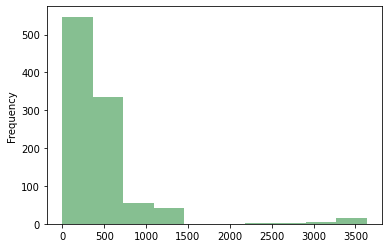

In [11]:
pd.options.mode.chained_assignment = None

ulimit = np.percentile(df.NumOfRetweets, 99)
df['NumOfRetweets'].loc[df['NumOfRetweets']>ulimit] = ulimit
llimit = np.percentile(df.NumOfRetweets.values, 1)
df['NumOfRetweets'].loc[df['NumOfRetweets']<llimit] = llimit
df['NumOfRetweets'].plot.hist(color='#86bf91')

In [12]:
def gen_microfactor_confirmation(df):
  df['ScaleConfirmation'] = df['NumOfRetweets']/df['NumOfRetweets'].mean()
  df['ScaleConfirmation'] = df['ScaleConfirmation'].apply(lambda x: 1 if x > 1 else x)
  df['Confirmation'] = df['ScaleConfirmation'].apply(lambda x: 'Positive' if x > 0.2 else 'Negative')

gen_microfactor_confirmation(df)

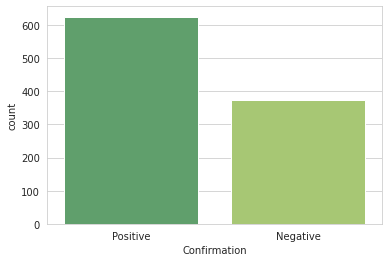

In [13]:
sns.set_style('whitegrid')
sns.countplot(x='Confirmation',data=df, palette='summer')

**2. Author Sentiment**

We use SentimentIntensityAnalyzer to detect the score of sentiment.

In [14]:
def get_text_sentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  _sentiment = analyzer.polarity_scores(text)["compound"]
  return abs(_sentiment)

In [15]:
df['ScaleSentiment'] = df['Statement'].apply(get_text_sentiment)
df['Sentiment'] = df['ScaleSentiment'].apply(lambda x: 'Positive' if float(x) > 0.4 else 'Negative')

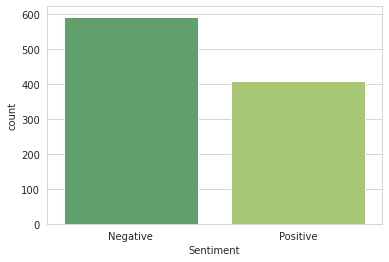

In [16]:
sns.set_style('whitegrid')
sns.countplot(x='Sentiment',data=df, palette='summer')

**3. Opinion Leader**

The opinion leaders are people who have many followers, we will use use number of followers of twitter user to detect the score of opinion leader.

In [17]:
def gen_microfactor_opinionleader(df):
  df['ScaleOpinionLeader'] = df['UserNumOfFollowers']/df['UserNumOfFollowers'].mean()
  df['ScaleOpinionLeader'] = df['ScaleOpinionLeader'].apply(lambda x: 1 if x > 1 else x)
  df['OpinionLeader'] = df['ScaleOpinionLeader'].apply(lambda x: 'Positive' if x > 0.2 else 'Negative')

gen_microfactor_opinionleader(df)

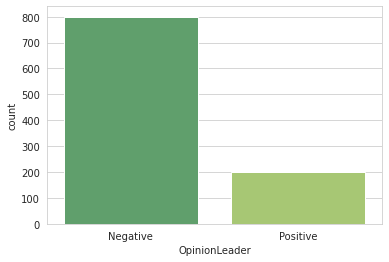

In [18]:
sns.set_style('whitegrid')
sns.countplot(x='OpinionLeader',data=df, palette='summer')

###2.2.Factor generation(Yuxing)
* Combine micro-factors to factor PsychologyUtilites using polynomial

In [19]:
# Get factor from micro factors by polynomial
df['ScalePsychology'] = df['ScaleConfirmation'] * 0.34 + df['ScaleSentiment'] * 0.33 + df['ScaleOpinionLeader'] * 0.33
df['PsychologyUtilites'] = df['ScalePsychology'].apply(lambda x: 'Positive' if x > 0.3 else 'Negative')

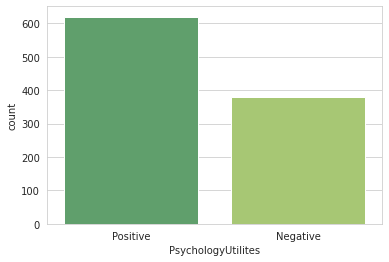

In [20]:
sns.set_style('whitegrid')
sns.countplot(x='PsychologyUtilites',data=df, palette='summer')

In [21]:
df.shape

(1000, 11)

**Construct a pipeline model with count vector Tfidf vector inside**

Pipeline includes vectorization tfidf transformer and SVM training

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib

# A pipeline with data preprocessing, training and prediction
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC(C=1, probability=True))
])

def data_to_pipeline(df, _source=None, _target=None, detailed_score=True):
  # Split data for training and validation
  X, y = df[_source].values, df[_target].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 
  
  # Training and prediction
  pipeline.fit(X_train, y_train)
  if detailed_score == False:
    scores = cross_val_score(pipeline, X_test, y_test, cv=3)
    print('now using %s to predict %s' % (_source, _target))
    print('cross validation scores:', scores)
    print('prediction score:', pipeline.score(X_test, y_test))
  else:
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
    scores = cross_validate(pipeline, X, y, cv=5,scoring=scoring)
    print("accuracy: %0.2f " % (scores['test_accuracy'].mean()))
    print("precision: %0.2f " % (scores['test_precision_macro'].mean()))
    print("recall: %0.2f " % (scores['test_recall_macro'].mean()))
    print("f1: %0.2f " % (scores['test_f1_macro'].mean()))
    print("roc_auc: %0.2f " % (scores['test_roc_auc'].mean()))
  # Save the pickle file
  pickle_filepath = '/content/' + _target + '_pipeline.pkl'
  joblib.dump(pipeline, pickle_filepath)
  print('pickle file is created:', pickle_filepath)
  print('\n')

In [23]:
def factor_1_pipeline(df):
  data_to_pipeline(df, _source='Statement', _target='Sentiment')
  data_to_pipeline(df, _source='Statement', _target='Confirmation')
  data_to_pipeline(df, _source='Statement', _target='OpinionLeader')
  data_to_pipeline(df, _source='Statement', _target='PsychologyUtilites')

factor_1_pipeline(df)

accuracy: 0.92 
precision: 0.94 
recall: 0.91 
f1: 0.92 
roc_auc: 0.98 
pickle file is created: /content/Sentiment_pipeline.pkl


accuracy: 0.97 
precision: 0.97 
recall: 0.98 
f1: 0.97 
roc_auc: 1.00 
pickle file is created: /content/Confirmation_pipeline.pkl


accuracy: 0.79 
precision: 0.53 
recall: 0.50 
f1: 0.46 
roc_auc: 0.57 
pickle file is created: /content/OpinionLeader_pipeline.pkl


accuracy: 0.91 
precision: 0.90 
recall: 0.91 
f1: 0.90 
roc_auc: 0.95 
pickle file is created: /content/PsychologyUtilites_pipeline.pkl




### 2.3.Microfactors generation (Mayuri)

**Generate Microfactors for Factor Intent**

**1. Utterance Score**

Where there are more sentences, there are more utterances. We can derive utterance from numberof sentences in the text.

In [24]:
from collections import Counter
import spacy

nlp = spacy.load('en_core_web_sm')

def get_sentences_num(text):
  _doc = nlp(text)
  sentences = list(_doc.sents)
  return len(sentences)

df['NumOfSent'] = df['Statement'].apply(get_sentences_num)

In [25]:
def gen_microfactor_utterance(df):
  df['ScaleUtterance'] = df['NumOfSent']/df['NumOfSent'].mean()
  df['ScaleUtterancen'] = df['ScaleUtterance'].apply(lambda x: 1 if x > 1 else x)
  df['Utterance'] = df['ScaleUtterance'].apply(lambda x: 'Positive' if x > 0.9 else 'Negative')

gen_microfactor_utterance(df)

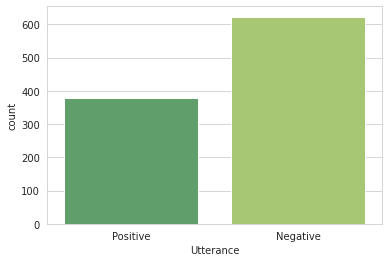

In [26]:
sns.set_style('whitegrid')
sns.countplot(x='Utterance',data=df, palette='summer')

**2.Speech Score**

Where there are more verbs and nouns, there are more speech to make. We can derive speech from numberof verbs and nouns in the text.

In [27]:
def get_verbnoun_num(text):
  _doc = nlp(text)
  _no_stopword_doc = [token for token in _doc if not token.is_stop]
  return len(_no_stopword_doc)

df['NumOfVerbNoun'] = df['Statement'].apply(get_verbnoun_num)

In [28]:
def gen_microfactor_speech(df):
  df['ScaleSpeech'] = df['NumOfVerbNoun']/df['NumOfVerbNoun'].mean()
  df['ScaleSpeech'] = df['ScaleSpeech'].apply(lambda x: 1 if x > 1 else x)
  df['Speech'] = df['ScaleSpeech'].apply(lambda x: 'Positive' if x > 0.95 else 'Negative')

gen_microfactor_speech(df)

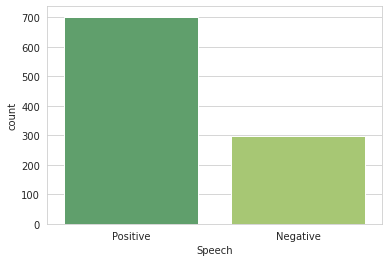

In [29]:
sns.set_style('whitegrid')
sns.countplot(x='Speech',data=df, palette='summer')

**3.Sentiment**

Sentiment is a micro factor of intent, also it is micro factor of psychology utility, which has been derived earlier.

In [30]:
df['ScaleSentiment'].head()

0    0.3182
1    0.3612
2    0.6249
3    0.6705
4    0.0000
Name: ScaleSentiment, dtype: float64

### 2.4.Factor generation(Mayuri)
* Combine micro-factors to factor Intent using polynomial

In [31]:
# Get factor from micro factors by polynomial
df['ScaleIntent'] = df['ScaleUtterancen'] * 0.3 + df['ScaleSpeech'] * 0.3 + df['ScaleSentiment'] * 0.4
df['Intent'] = df['ScaleIntent'].apply(lambda x: 'Positive' if x > 0.65 else 'Negative')

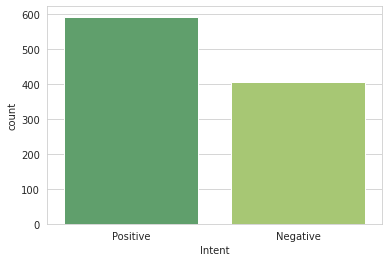

In [32]:
sns.set_style('whitegrid')
sns.countplot(x='Intent',data=df, palette='summer')

###2.5.Factor generation (Arun)

In [33]:
def factor_2_pipeline(df):
  data_to_pipeline(df, _source='Statement', _target='Utterance')
  data_to_pipeline(df, _source='Statement', _target='Speech')
  data_to_pipeline(df, _source='Statement', _target='Intent')

factor_2_pipeline(df)

accuracy: 0.95 
precision: 0.96 
recall: 0.93 
f1: 0.95 
roc_auc: 0.98 
pickle file is created: /content/Utterance_pipeline.pkl


accuracy: 0.91 
precision: 0.91 
recall: 0.86 
f1: 0.88 
roc_auc: 0.98 
pickle file is created: /content/Speech_pipeline.pkl


accuracy: 0.93 
precision: 0.93 
recall: 0.94 
f1: 0.93 
roc_auc: 0.99 
pickle file is created: /content/Intent_pipeline.pkl




## 3.Team Work

###3.1.Load the pickled models for microfactors

In [34]:
! ls -l /content/*.pkl

-rw-r--r-- 1 root root 155636 May 18 00:54 /content/Confirmation_pipeline.pkl
-rw-r--r-- 1 root root 152855 May 18 00:57 /content/Intent_pipeline.pkl
-rw-r--r-- 1 root root 188540 May 18 00:54 /content/OpinionLeader_pipeline.pkl
-rw-r--r-- 1 root root 162164 May 18 00:54 /content/PsychologyUtilites_pipeline.pkl
-rw-r--r-- 1 root root 152639 May 18 00:54 /content/Sentiment_pipeline.pkl
-rw-r--r-- 1 root root 152063 May 18 00:57 /content/Speech_pipeline.pkl
-rw-r--r-- 1 root root 151199 May 18 00:57 /content/Utterance_pipeline.pkl
-rw-r--r-- 1 root root   5570 May 18 00:52 /content/Verdict_pipeline.pkl


In [35]:
import joblib

microfactor_list = [
                    'Sentiment', 
                    'Confirmation', 
                    'OpinionLeader',
                    'Utterance',
                    'Speech',
                    'Intent'
                  ]

def get_micrafactor_from_pickles_(df):
  # Preprocessing
  df['Statement'] = df['Statement'].apply(get_text_processing)
  statement = df['Statement'].to_numpy()
  for microfactor in microfactor_list:
    print('generating microfactor :', microfactor)
    # load microfactor pickle
    pickle_filepath = '/content/{}_pipeline.pkl'.format(microfactor)
    microfactor_model = joblib.load(open(pickle_filepath, 'rb'))
    # create new microfact column
    df[microfactor] = microfactor_model.predict_proba(statement)[:,1]
    df[microfactor] = df[microfactor].apply(lambda x: float(x))


###3.2.Ensemble a true-o-meter classification pipeline

**Use politicfact dataset to generate microfactors and train Verdict**

In [36]:
df = df_politifact.copy()
get_micrafactor_from_pickles_(df)

generating microfactor : Sentiment
generating microfactor : Confirmation
generating microfactor : OpinionLeader
generating microfactor : Utterance
generating microfactor : Speech
generating microfactor : Intent


In [37]:
df.head()

,Date,Issue,Reporter,Author,Statement,Description,Verdict,Url,Sentiment,Confirmation,OpinionLeader,Utterance,Speech,Intent
0,"May 7, 2021",Abortion,Bill McCarthy,Facebook posts,Says Chelsea Clinton tweeted Jesus alive today...,"stated on May 7, 2021 in a Facebook post:",pants-fire,/personalities/facebook-posts/,0.330274,0.089475,0.199147,0.107405,0.572015,0.285027
1,"March 31, 2021",Abortion,Tom Kertscher,Facebook posts,“Joe Biden puts prolife groups domestic extrem...,"stated on March 29, 2021 in a Facebook post:",barely-true,/personalities/facebook-posts/,0.776938,0.114538,0.209153,0.349909,0.481800,0.759612
2,"February 12, 2021",Abortion,Brandon Mulder,Greg Abbott,“Innocent lives saved” ending taxpayer funding...,"stated on January 24, 2021 in a tweet:",false,/personalities/greg-abbott/,0.641573,0.079537,0.201767,0.130227,0.739028,0.556390
3,"November 18, 2020",Abortion,Noah Y. Kim,Facebook posts,“aborted male fetus” OxfordAstraZeneca “Covid ...,"stated on November 15, 2020 in a Facebook post:",false,/personalities/facebook-posts/,0.097020,0.084863,0.197943,0.310105,0.828584,0.140971
4,"October 14, 2020",Abortion,Tom Kertscher,Tommy Tuberville,Says Doug Jones voted spend tax dollars latete...,"stated on October 8, 2020 in an ad:",false,/personalities/tommy-tuberville/,0.257453,0.223408,0.202277,0.092605,0.597155,0.337705


**Use ensembled model and microfactors to train Verdict, model will be pickled in data_to_pipeline processing**

In [38]:
pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('svm', SVC(C=1, probability=True))
])

data_to_pipeline(df, _source = microfactor_list, _target = 'Verdict', detailed_score=False)

now using ['Sentiment', 'Confirmation', 'OpinionLeader', 'Utterance', 'Speech', 'Intent'] to predict Verdict
cross validation scores: [0.22916667 0.23404255 0.17021277]
prediction score: 0.20422535211267606
pickle file is created: /content/Verdict_pipeline.pkl




###3.3.Automated Inference Pipeline


**Load pickled true-o-meter pipeline**

In [39]:
pickle_filepath = '/content/Verdict_pipeline.pkl'
o_meter_model = joblib.load(open(pickle_filepath, 'rb'))

**Read a new piece of data from politifact**

In [40]:
records = scrape_data_from_politifact(start=12, end=13)
df = pd.DataFrame(records, columns=['Date', 'Issue','Reporter','Author', 'Statement', 'Description', 'Verdict', 'Url'])  

**Predict and compare the Verdict**

In [41]:
get_micrafactor_from_pickles_(df)
df['pred_verdict'] = o_meter_model.predict(df[microfactor_list])
df_intestest = df[['Statement', 'Verdict', 'pred_verdict']]
df_intestest

generating microfactor : Sentiment
generating microfactor : Confirmation
generating microfactor : OpinionLeader
generating microfactor : Utterance
generating microfactor : Speech
generating microfactor : Intent


,Statement,Verdict,pred_verdict
0,Central Health hospital district Texas spends ...,true,barely-true
1,US Government Accountability Office report say...,pants-fire,false
2,Studies shown absence federal reproductive hea...,half-true,false
3,Says bill HB 97 would prevent use taxpayer dol...,false,false
4,child born prematurely according president wor...,pants-fire,false
5,Says women need sonogram eighth 10th week preg...,mostly-true,false
6,proposed Georgia law women miscarry could beco...,mostly-true,half-true
7,miscarriage considered abortion,half-true,half-true
8,80000 abortions Texas every year,true,barely-true
9,Says Ohio right could 8½ months pregnant abort...,mostly-true,half-true


In [42]:
df['pred_verdict'].unique()

array(['barely-true', 'false', 'half-true', 'mostly-true'], dtype=object)

In [43]:
df['verdict_norm'] = df['Verdict'].apply(lambda x: 'True' if x in ['true', 'mostly-true'] else 'False')
df['pred_verdict_norm'] = df['pred_verdict'].apply(lambda x: 'True' if x in ['true', 'mostly-true'] else 'False')

In [44]:
df_intestest = df[['Statement', 'verdict_norm', 'pred_verdict_norm']]
df_intestest

,Statement,verdict_norm,pred_verdict_norm
0,Central Health hospital district Texas spends ...,True,False
1,US Government Accountability Office report say...,False,False
2,Studies shown absence federal reproductive hea...,False,False
3,Says bill HB 97 would prevent use taxpayer dol...,False,False
4,child born prematurely according president wor...,False,False
5,Says women need sonogram eighth 10th week preg...,True,False
6,proposed Georgia law women miscarry could beco...,True,False
7,miscarriage considered abortion,False,False
8,80000 abortions Texas every year,True,False
9,Says Ohio right could 8½ months pregnant abort...,True,False


**Pickle the models**

In [45]:
from google.colab import drive
drive.mount('/content/drive')
! cp /content/*.pkl /content/drive/MyDrive/pickles_nlp/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
